In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.util import random_rotation, find_permutation

## Ring attractor

https://www.sciencedirect.com/science/article/pii/S0896627318303258

In [2]:
###Ring attractor (multi-attractor) model
Neu = 100  #number of cells
taum = 0.01  #membrain time constant
k = 0.1  #gain
gm = 100  #conductance
Wa = -40/gm  #average weight
Wd = 33/gm  #tuning-dependent


In [3]:
###synaptic weights
Wij = np.zeros((Neu,Neu))  #connectivity matrix
deg2rad = np.pi/180
ths = np.linspace(-90,90,Neu)*deg2rad  #preferred tuning direction
for ii in range(Neu):
    for jj in range(Neu):
        Wij[ii,jj] = Wa + Wd/Neu*np.cos(ths[ii]-ths[jj])
        #np.exp( (np.cos(ths[ii]-ths[jj])-1)/lsyn**2 )
Wij = (Wij-np.mean(Wij))*1  ##??

Text(0, 0.5, 'j')

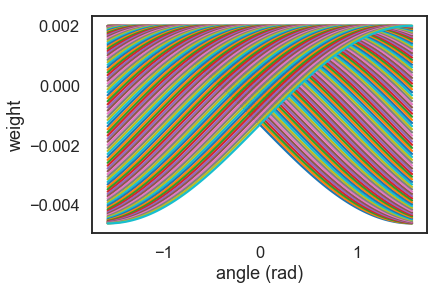

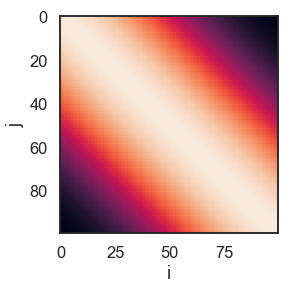

In [4]:
plt.plot(ths,Wij);
plt.xlabel('angle (rad)')
plt.ylabel('weight')
plt.figure()
plt.imshow(Wij)
plt.xlabel('i')
plt.ylabel('j')

In [5]:
###stimulus
T = 100  #sec
dt = 0.01  #10ms
time = np.arange(0,T,dt)  #time series

b = 2
c = 0.5
Am = 0.1
def the2h(ti,tstim):
    return b + c*(1-Am+Am*np.cos(ti-tstim))
#b + c*Am*np.exp( (np.cos(ti-tstim)-1)/lstim**2 )

taun = 10  #noise correlation
noise = 10
h = np.zeros(len(time))
for tt in range(0,len(time)-1):
    h[tt+1] = h[tt] + (ths[int(len(ths)/2)]-h[tt])*dt/taun + np.sqrt(taun*dt)*np.random.randn()*noise
#     if h[tt+1]>180:
#         h[tt+1] = h[tt+1]-180
#     if h[tt+1]<0:
#         h[tt+1] = 180+h[tt+1]
#h = h*deg2rad
        
# smoothed = 200
# temp = np.convolve(np.random.randn(len(time))*180,np.exp(-np.arange(1,smoothed,1)/smoothed),'same')
h = np.mod(h,180)*deg2rad - np.pi/2

Text(0, 0.5, 'head angle (rad)')

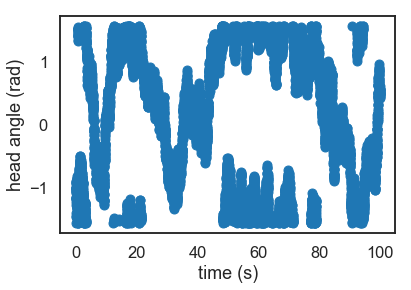

In [6]:
plt.plot(time,h,'o')
plt.xlabel('time (s)')
plt.ylabel('head angle (rad)')

In [9]:
###neural dynamics
Vr = 0
V = np.zeros((Neu,len(time)))  #neurons by time
V[:,0] = Vr + np.random.randn(Neu)  #initialization
r = np.zeros((Neu,len(time)))
r[:,0] = gm*np.tanh(k*V[:,0])  #k*(np.max((V[:,0]-V0)))**nn

for tt in range(0,len(time)-1):
    ht = np.array([the2h(hh,h[tt]) for hh in ths])  #input bump
    V[:,tt+1] = V[:,tt] + dt*(-V[:,tt] + ht + np.dot(Wij,r[:,tt]))/taum + np.sqrt(dt*taum)*np.random.randn(Neu)*1
    temp = V[:,tt+1].copy()
    temp[temp<0] = 0
    r[:,tt+1] = gm*np.tanh(k*temp)  #k*(np.max((V[:,tt+1]-V0)))**nn

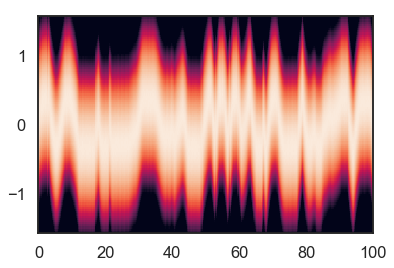

In [10]:
extent = [0,T,ths[0],ths[-1]]
plt.imshow(r, aspect="auto",extent=extent)
#plt.plot(V.T);

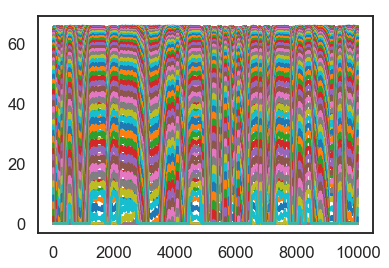

In [11]:
plt.plot(r[:,2:].T);

In [12]:
###PCA test
X = r[:,2:].copy()
C = np.cov(X)
u,s,v = np.linalg.svd(C)
PCs = np.dot(u[:,:3].T,X)

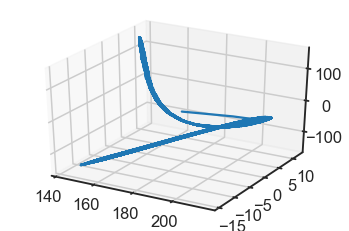

In [13]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.plot3D(PCs[1,:], PCs[2,:], PCs[0,:])

## SLDS fitting

In [14]:
XX = np.array(X[np.random.choice(np.arange(0,Neu,1),10),:])
XX = XX[:,np.arange(0,len(time),10)]
#XX = X.copy()

(10, 1000)

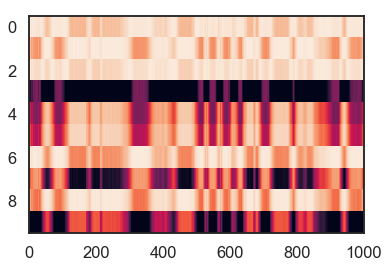

In [15]:
plt.imshow(XX, aspect="auto")
XX.shape

In [16]:
# Set the parameters of the HMM
T = XX.shape[1]    # number of time bins
K = 3       # number of discrete states
D = 2       # number of latent dimensions
N = XX.shape[0]      # number of observed dimensions

In [17]:
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(N, K, D, transitions="recurrent_only", emissions="gaussian_orthog")
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
z, x, y = true_slds.sample(T)

# Mask off some data
y = XX.T.copy()
mask = npr.rand(T, N) < 0.9
y_masked = y * mask

In [18]:
print("Fitting SLDS with SVI")

# Create the model and initialize its parameters
slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
slds.initialize(y_masked, masks=mask)

# Create a variational posterior
q_mf = SLDSMeanFieldVariationalPosterior(slds, y_masked, masks=mask)
q_mf_elbos = slds.fit(q_mf, y_masked, masks=mask, num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_mf_x, y)))
q_mf_z = slds.most_likely_states(q_mf_x, y)

# Smooth the data under the variational posterior
q_mf_y = slds.smooth(q_mf_x, y)

Fitting SLDS with SVI
Initializing with an ARHMM using 25 steps of EM.


/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [19]:
print("Fitting SLDS with SVI using structured variational posterior")
slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
slds.initialize(y_masked, masks=mask)

q_struct = SLDSTriDiagVariationalPosterior(slds, y_masked, masks=mask)
q_struct_elbos = slds.fit(q_struct, y_masked, masks=mask, num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_struct_x = q_struct.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_struct_x, y)))
q_struct_z = slds.most_likely_states(q_struct_x, y)

# Smooth the data under the variational posterior
q_struct_y = slds.smooth(q_struct_x, y)

Fitting SLDS with SVI using structured variational posterior
Initializing with an ARHMM using 25 steps of EM.


/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [20]:
###try with switching!
rslds = ssm.SLDS(N, K, D, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)

q = SLDSTriDiagVariationalPosterior(rslds, y)
elbos = rslds.fit(q, y, num_iters=1000, initialize=False)

Initializing with an ARHMM using 25 steps of EM.


/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/Macintosh/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multid

Text(0, 0.5, 'ELBO')

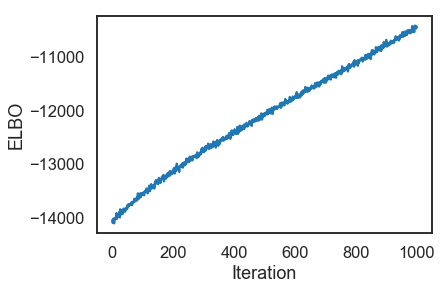

In [21]:
xhat = q.mean[0]

# Find the permutation that matches the true and inferred states
rslds.permute(find_permutation(z, rslds.most_likely_states(xhat, y)))
zhat = rslds.most_likely_states(xhat, y)

plt.figure()
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

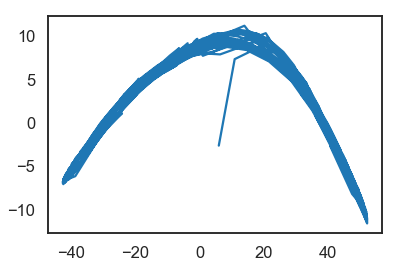

In [22]:
plt.plot(xhat[:,0],xhat[:,1])

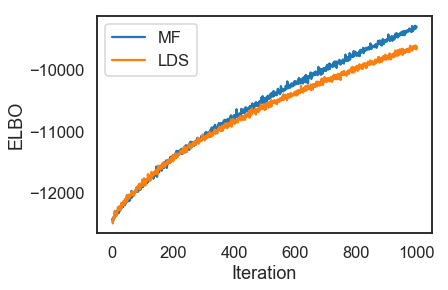

In [23]:
# Plot the ELBOs
plt.plot(q_mf_elbos, label="MF")
plt.plot(q_struct_elbos, label="LDS")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

Text(0, 0.5, 'angle (rad)')

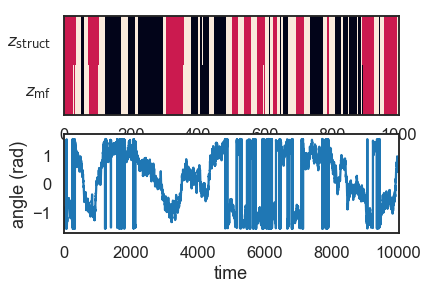

In [24]:
###discrete state vs. head direction
plt.subplot(211)
plt.imshow(np.row_stack((q_struct_z, q_mf_z)), aspect="auto")
plt.yticks([0, 1], ["$z_{\\mathrm{struct}}$", "$z_{\\mathrm{mf}}$"])
plt.subplot(212)
plt.plot(h)
plt.xlim(0,len(h))
plt.xlabel('time')
plt.ylabel('angle (rad)')

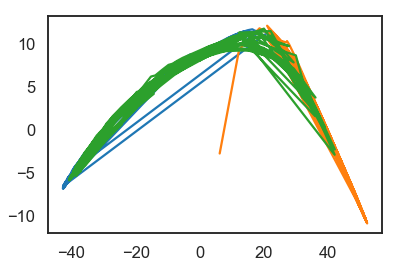

In [25]:
for kk in range(K):
    pos = np.where(q_struct_z==kk)[0]
    plt.plot(q_struct_x[pos,0],q_struct_x[pos,1])

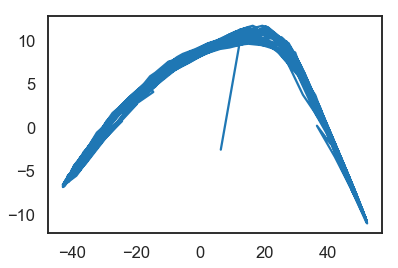

In [26]:
plt.plot(q_mf_x[:,0],q_mf_x[:,1])

In [27]:
# Plot the true and inferred states
# xlim = (0, 500)

# plt.figure(figsize=(8,4))
# plt.imshow(np.row_stack((z, q_struct_z, q_mf_z)), aspect="auto")
# plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
# plt.yticks([0, 1, 2], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{struct}}$", "$z_{\\mathrm{mf}}$"])
# plt.xlim(xlim)

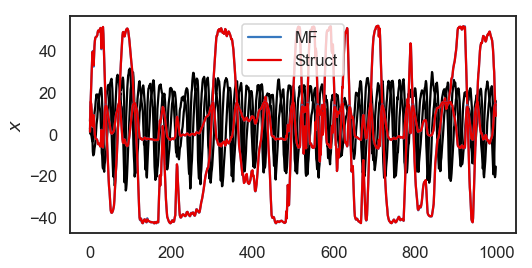

In [30]:
plt.figure(figsize=(8,4))
plt.plot(x + 4 * np.arange(D), '-k')
for d in range(D):
    plt.plot(q_mf_x[:,d] + 4 * d, '-', color=colors[0], label="MF" if d==0 else None)
    plt.plot(q_struct_x[:,d] + 4 * d, '-', color=colors[1], label="Struct" if d==0 else None)
plt.ylabel("$x$")
#plt.xlim(xlim)
plt.legend()

Text(0.5, 0, 'time')

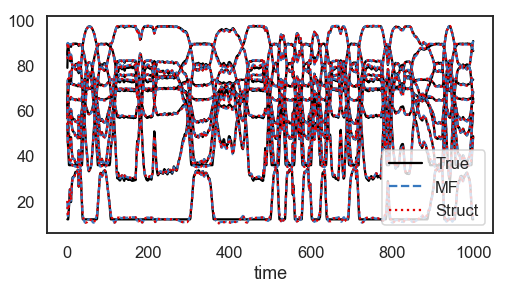

In [31]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
for n in range(N):
    plt.plot(y[:, n] + 4 * n, '-k', label="True" if n == 0 else None)
    plt.plot(q_mf_y[:, n] + 4 * n, '--', color=colors[0], label="MF" if n == 0 else None)
    plt.plot(q_struct_y[:, n] + 4 * n, ':',  color=colors[1], label="Struct" if n == 0 else None)
plt.legend()
plt.xlabel("time")
#plt.xlim(xlim)